<a href="https://colab.research.google.com/github/Harshkotkar/Deep-Learning/blob/main/Early_Detection_of_Diabetic_Retinopathy_from_Retinal_Fundus_Images(full_and_final_%F0%9F%A4%AF%F0%9F%94%A5).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
# # IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# # RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
# import kagglehub
# kagglehub.login()


In [2]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

aptos2019_blindness_detection_path = kagglehub.competition_download('aptos2019-blindness-detection')

print('Data source import complete.')


100%|██████████| 9.51G/9.51G [01:27<00:00, 117MB/s] 

Extracting files...


Data source import complete.


In [3]:
 # This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [20]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.metrics import roc_curve, auc, precision_recall_curve



In [5]:
import os

print(aptos2019_blindness_detection_path)  # This shows the base folder
print(os.listdir(aptos2019_blindness_detection_path))  # List what’s inside


/root/.cache/kagglehub/competitions/aptos2019-blindness-detection
['test_images', 'sample_submission.csv', 'test.csv', 'train_images', 'train.csv']


In [6]:
import os
import pandas as pd

# Base dataset path
base_path = "/root/.cache/kagglehub/competitions/aptos2019-blindness-detection"

# Load CSVs
train_df = pd.read_csv(os.path.join(base_path, "train.csv"))
test_df = pd.read_csv(os.path.join(base_path, "test.csv"))

print(train_df.head())
print(test_df.head())


        id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0
        id_code
0  0005cfc8afb6
1  003f0afdcd15
2  006efc72b638
3  00836aaacf06
4  009245722fa4


In [7]:
base_path = "/root/.cache/kagglehub/competitions/aptos2019-blindness-detection"
train_imgs = os.path.join(base_path, "train_images")

In [8]:
train_df = pd.read_csv(os.path.join(base_path, "train.csv"))
test_df = pd.read_csv(os.path.join(base_path, "test.csv"))

In [9]:
train_df["id_code"] = train_df["id_code"].str.replace(r"(\.png)+$", ".png", regex=True)
test_df["id_code"]  = test_df["id_code"].str.replace(r"(\.png)+$", ".png", regex=True)

In [10]:
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['diagnosis'], random_state=42)


In [11]:
# Ensure .png extension is appended correctly
train_df["id_code"] = train_df["id_code"].astype(str).str.replace(r"(\.png)+$", "", regex=True) + ".png"
val_df["id_code"]   = val_df["id_code"].astype(str).str.replace(r"(\.png)+$", "", regex=True) + ".png"

print(train_df.head())
print(val_df.head())

               id_code  diagnosis
2579  b2b79b37d314.png          0
309   175dd560810a.png          2
2826  c3cd0200df79.png          3
2989  cfed7c1172ec.png          0
3344  e811f39a1243.png          2
               id_code  diagnosis
1595  6fe67fd7f5d1.png          0
3449  ef8c39eb9157.png          0
1394  61bbc11fe503.png          4
1379  60edda7b4871.png          0
3043  d30d079e6f9a.png          0


In [12]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])


In [13]:
IMG_SIZE = 224
BATCH_SIZE = 32

def load_image(img_id, label, augment=False):
    img_path = tf.strings.join([train_imgs, "/", img_id])
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = preprocess_input(img)  # EfficientNet-specific preprocessing
    if augment:
        img = data_augmentation(img)
    return img, label


In [14]:
train_ds = tf.data.Dataset.from_tensor_slices((train_df["id_code"].values, train_df["diagnosis"].values))
train_ds = train_ds.map(lambda x, y: load_image(x, y, augment=True), num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(1024).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [15]:
val_ds = tf.data.Dataset.from_tensor_slices((val_df["id_code"].values, val_df["diagnosis"].values))
val_ds = val_ds.map(lambda x, y: load_image(x, y, augment=False), num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)



In [16]:
#class imbalance
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(train_df['diagnosis']),
                                     y=train_df['diagnosis'])
class_weights = dict(enumerate(class_weights))


In [17]:
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base layers initially

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(5, activation='softmax')  # 5 classes for APTOS
])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [18]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,214,184 (16.08 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [19]:
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=10,
                    class_weight=class_weights,
                    verbose=1)


Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 317s 2s/step - accuracy: 0.4838 - loss: 1.4184 - val_accuracy: 0.6112 - val_loss: 0.8637
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 305s 2s/step - accuracy: 0.6412 - loss: 1.0834 - val_accuracy: 0.6330 - val_loss: 0.8500
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 317s 2s/step - accuracy: 0.6723 - loss: 0.9616 - val_accuracy: 0.7231 - val_loss: 0.7332
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 290s 2s/step - accuracy: 0.7210 - loss: 0.9015 - val_accuracy: 0.6180 - val_loss: 0.8586
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 288s 2s/step - accuracy: 0.7129 - loss: 0.9030 - val_accuracy: 0.6248 - val_loss: 0.8483
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 289s 2s/step - accuracy: 0.7146 - loss: 0.9271 - val_accuracy: 0.7231 - val_loss: 0.7727
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 285s 2s/step - accuracy: 0.7495 - loss: 0.8356 - val_accuracy: 0.7367 - val_loss: 0.7097
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 299s 2s/step - accuracy: 0.7221 - loss: 0.8906 - val_accuracy: 0.7258 - v

In [21]:
val_loss, val_acc = model.evaluate(val_ds, verbose=1)
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.6642 - loss: 0.7686
Validation Accuracy: 0.6617
Validation Loss: 0.8053


In [31]:
# Extract true labels
y_true = []
for _, labels in val_ds:
    y_true.extend(labels.numpy())
y_true = np.array(y_true)

# Get predicted probabilities
y_pred_probs = model.predict(val_ds)


23/23 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step


## Grad-CAM


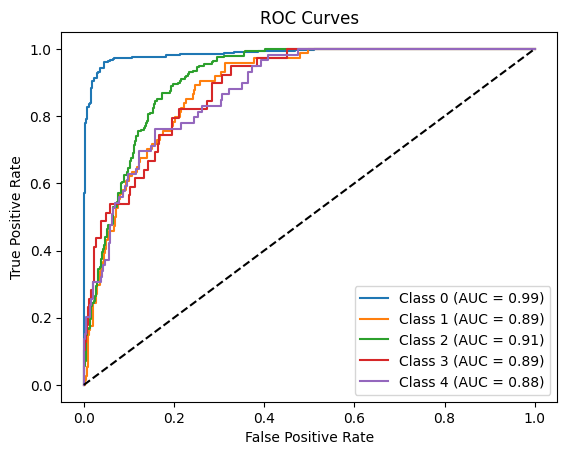

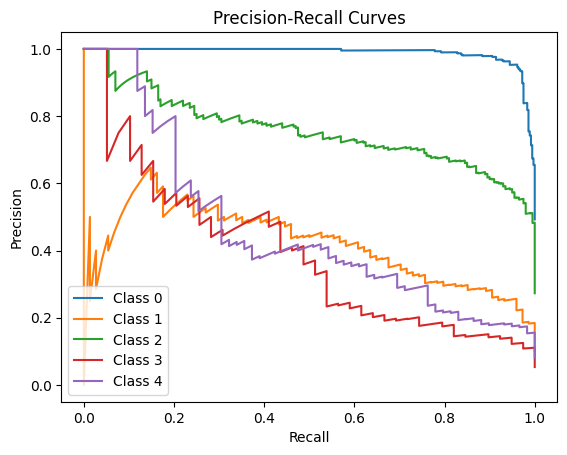

In [32]:
#auc roc curve

def plot_roc_pr(y_true, y_probs, num_classes=5):
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve((y_true == i).astype(int), y_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves")
    plt.legend()
    plt.show()

    for i in range(num_classes):
        precision, recall, _ = precision_recall_curve((y_true == i).astype(int), y_probs[:, i])
        plt.plot(recall, precision, label=f"Class {i}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curves")
    plt.legend()
    plt.show()
plot_roc_pr(y_true, y_pred_probs)

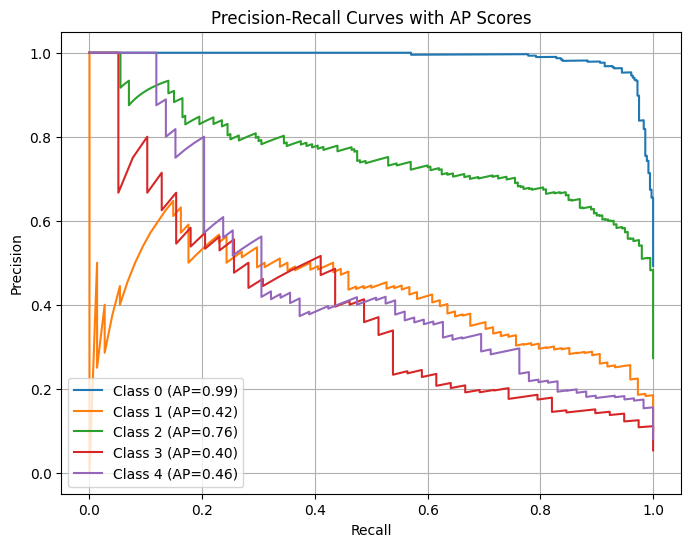

In [33]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Assuming y_true and y_pred_probs are already defined
n_classes = y_pred_probs.shape[1]
ap_scores = []

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_true == i, y_pred_probs[:, i])
    ap = average_precision_score(y_true == i, y_pred_probs[:, i])
    ap_scores.append(ap)
    plt.plot(recall, precision, label=f'Class {i} (AP={ap:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves with AP Scores')
plt.legend()
plt.grid(True)
plt.show()


In [34]:
# true label and prediction label
# Get true labels
y_true = np.concatenate([y.numpy() for _, y in val_ds], axis=0)
# Get predicted labels
y_pred_probs = model.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)


23/23 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step


In [ ]:
# classification report
print(classification_report(y_true, y_pred, target_names=class_names))

In [ ]:
#  confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Plot it
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
